In [1]:
# import SharedArray as sa
# ROBOT_TYPE_NAME = 'panda'
# sa.delete("shm://{}.prepared".format(ROBOT_TYPE_NAME))
# sa.delete("shm://{}.grasp_img".format(ROBOT_TYPE_NAME))
# sa.delete("shm://{}.arm_img".format(ROBOT_TYPE_NAME))
# sa.delete("shm://{}.rh_vals".format(ROBOT_TYPE_NAME))
# sa.delete("shm://{}.result".format(ROBOT_TYPE_NAME))
# sa.delete("shm://{}.query_in".format(ROBOT_TYPE_NAME))
# sa.delete("shm://{}.response_out".format(ROBOT_TYPE_NAME))
# sa.delete("shm://{}.query_quit".format(ROBOT_TYPE_NAME))

## Define printing function

In [1]:
from __future__ import print_function
import os
RNB_PLANNING_DIR = os.environ["RNB_PLANNING_DIR"]
os.chdir(os.path.join(RNB_PLANNING_DIR, 'src'))
from pkg.controller.combined_robot import *
from pkg.utils.utils import get_now, try_mkdir
from pkg.planning.pddlstream.convert_pscene import *
import subprocess

def print_results(RES_ROOT, RTYPE, DAT_DIR, CNAME_LIST=['None','Tool','ToolReach','Full'] #,'Pairwise']
                  , CNAMES_EXCLUDE=['None'], exp_list=['obj_1', 'obj_1_obs3', 'obj_1_obs5', 'obj_3', 'obj_3_pole', 'obj_3_hard', 
                                                       'obj_1c_obs0', 'obj_1c_obs3', 'obj_1c_obs5', 'obj_1c_obs7', 
                                                       'obj_3c_obs3', 'obj_3c_obs5', 'obj_3c_obs7']
                  , read_only=False
                 ):
    DATA_PATH = os.path.join(RNB_PLANNING_DIR, "data")
    try_mkdir(DATA_PATH)

    # RES_ROOT = "stowing-result"
    # RES_ROOT = "stowing-deep-result-before-ik-only2"
    # RES_ROOT = "stowing-result-pddl-fin"

    TEST_RESULT_PATH = os.path.join(DATA_PATH, RES_ROOT)
    try_mkdir(TEST_RESULT_PATH)

    HEADS = np.array(["plan_time", "length", "MP_tot", "MP_count", "failed_MPs", "IK_tot", "IK_count", "failed_IKs", "success"])
    DISPS = np.array(["Time", "Actions", "MP_tot", "MP trials", "MP fails", "IK_tot", "IK trials", "IK fails", "Fail(%)", "Total"])
    H2D = {}
    D2H = {}
    for head, disp in zip(HEADS, DISPS):
        H2D[head] = disp
        D2H[disp] = head

    # DAT_DIR = '20210702-152658'
    # DAT_DIR = '20210707-034434'
    # DAT_DIR = '20210709-172009'
    # DAT_DIR = '20210820-162838'


    # RTYPE = "panda"
    # DAT_DIR = '20210705-182244'
    # FILE_OPTION = "obj_1"
    # # DAT_DIR, FILE_OPTION = "20210613-022832", "obj_1"
    # # # DAT_DIR, FILE_OPTION = "20210612-221934", "obj_1"

    GRASP_SAMPLE = 100
    VISUALIZE = True
    PLAY_RESULT = False
    SHOW_STATE = False

    TIMEOUT_MOTION = 5
    MAX_TIME = 100
    MAX_ITER = 100

    ROBOT_DATA_ROOT = os.path.join(TEST_RESULT_PATH, RTYPE)
    DATASET_PATH = os.path.join(ROBOT_DATA_ROOT, DAT_DIR)
    file_list = sorted(os.listdir(DATASET_PATH))


    print("="*50)
    print("RES_ROOT: {}".format(RES_ROOT))
    print("DAT_DIR: {}".format(DAT_DIR))
    print("CNAME_LIST: {}".format(CNAME_LIST))
    print("="*50)

    resdat_all = defaultdict(lambda: defaultdict(list))
    res_dict_all = defaultdict(lambda: defaultdict(list))
    resfile_list = sorted(os.listdir(os.path.join(DATASET_PATH)))
    for resfile in resfile_list:
        if resfile.startswith("."):
            continue
        args = resfile[:-4].split("_")[1:]
        f_option = "_".join(args[:-2])
        fid, cname = args[-2:]
        resdat = load_pickle(os.path.join(DATASET_PATH, resfile))
        resdat_all[f_option][cname].append(resdat)
        res_dict_all[f_option][cname].append([resdat[head] if head in resdat else None for head in HEADS])
    if read_only:
        return resdat_all, res_dict_all
    
    for ekey in exp_list:
        print(ekey)
        if ekey not in res_dict_all:
            continue

        ## Check result file sanity
        fnames_dict = {}
        imax_min = None
        for cname in CNAME_LIST:
            fnames_dict[cname] = [int(fname.split("_")[-2]) for fname in resfile_list 
                                  if (ekey == "_".join(fname.split("_")[1:-2])
                                      and cname == fname.split("_")[-1].split(".")[0])]
            len_fnames = len(fnames_dict[cname])
            if len_fnames > 0:
                imax =max(fnames_dict[cname])
                imax_min = min([imax, imax_min]) if imax_min is not None else imax
                print("{} files: {}".format(cname, len_fnames))

        ## Print missing file if any
        missing_any = False
        for cname in CNAME_LIST:
            if len(fnames_dict[cname]) > 0:
                idc_missing = set(np.arange(imax_min+1))-set(fnames_dict[cname])
                if len(idc_missing) > 0:
                    missing_any = True
                    print("{} missing {}".format(cname, idc_missing))

        if missing_any:
            print("Skip as there's missing result")
            continue

        res_dict = res_dict_all[ekey]

        succ_vec_list = []
        len_list = []
        None_cols = []
        CNAME_LIST_CUR = [cname for cname in CNAME_LIST if cname in res_dict]
        len_tests = None
        for cname in CNAME_LIST_CUR:
            vv = np.array(res_dict[cname])[:imax_min+1]
            if len_tests is not None:
                assert len_tests == len(vv), "data length mismatch"
            else:
                len_tests = len(vv)
            if len(vv)>0:
                None_cols.append(np.any(np.equal(vv, None), axis=0))
                succ_vec = vv[:,-1]
                succ_vec_list.append(succ_vec)
                len_list.append(len(succ_vec))
                if cname in CNAMES_EXCLUDE:
                    fail_vec = np.logical_not(succ_vec)
                    idc_fail_none = np.where(fail_vec)[0]
        print("="*50 + " {:<10} ".format(ekey) + "="*50, end="\r")
        if len(len_list)>0:
            None_cols = np.any(None_cols, 0)
            good_cols = np.where(np.logical_not(None_cols))[0]
            idc_include = [i_cn for i_cn, cname in enumerate(CNAME_LIST_CUR) if cname not in CNAMES_EXCLUDE]
            min_len = np.min(np.array(len_list)[idc_include])
            succ_vec_all = np.all([svec[:min_len] for svec in 
                                   np.array(succ_vec_list)[idc_include]], axis=0)
            idc_succ_all = np.where(succ_vec_all)[0]
            tot_cols = set(np.where([chead.endswith("tot") for chead in DISPS[good_cols]])[0])
            print("="*50 + " {:<10} ".format(ekey) + "="*50 + " valid={}".format(len(idc_succ_all)))
            print(("{:<10}:"
                   + "".join([
                       " {:>8}" 
                       if not tot_cols.intersection([i_col-1, i_col-2])
                       else " {:>15}" 
                       for i_col in range(len(good_cols))])).format(
                "Checker", *DISPS[good_cols])+" {:>8}".format(DISPS[-1]))
            hard_vec_list = []
            for cname in CNAME_LIST_CUR:
                vv = np.array(res_dict[cname][:imax_min+1])[:, good_cols]
                if len(vv)>0:
                    succ_vec = vv[:,-1]
                    fail_vec = np.logical_not(succ_vec)
                    hard_vec_list.append(vv[:min_len, 0] > np.mean(vv[:min_len, 0])*1.0)
                    if cname in CNAMES_EXCLUDE:
                        idc_succ_now = np.where(succ_vec)[0]
                        idc_fail_none = np.where(fail_vec)[0]
                    else:
    #                     idc_succ_now = np.where(succ_vec)[0]
                        idc_succ_now = idc_succ_all
                    print(
                        "{:<10}:".format(cname) # Case name
                        + "".join([
                            " {:>8}".format(np.round(np.mean(vv[idc_succ_now, i_col]), 2))
                            + (""
                            if not tot_cols.intersection([i_col-1, i_col-2]) 
                            else 
                            "({:>5})".format(np.round(np.mean(vv[idc_succ_now, i_col]/vv[idc_succ_now, i_col-1]*100), 2)))
                            for i_col in range(vv.shape[-1]-1)]) # data values
                        + " {:>8} {:>8}".format(np.round(float(np.sum(fail_vec))/len(vv)*100, 2), len(vv))) # meta data
    return resdat_all, res_dict_all

def print_debug_info(resdat_all, 
                     CNAME_LIST=['None','Tool','ToolReach','Full'], 
                     exp_list = ['obj_1', 'obj_1_obs3', 'obj_1_obs5', 'obj_3', 'obj_3_pole', 'obj_3_hard', 'obj_3_obs3', 'obj_3_obs5']):
    print("==============================================")
    print("============== Checker Results ===============")
    for exp in exp_list:
        print("---------- {:10} ----------".format(exp))
        print("{:11} {:>10} {:>10} {:>10}".format("", "accuracy", "precision", "recall"))
        for cname in CNAME_LIST:
            pre_motion_checks = [dat['pre_motion_checks'] for dat in resdat_all[exp][cname]]
            planning_log = [dat['planning_log'] for dat in resdat_all[exp][cname]]
            assert len(pre_motion_checks) == len(planning_log), "MP reseult length mismatch"
            if len(pre_motion_checks)>0:
                pre_motion_checks = np.concatenate(pre_motion_checks)
                planning_log = np.concatenate(planning_log)
                print("{:10}: {:>8} % {:>8} % {:>8} %".format(cname, 
                                                                    round(np.mean(np.equal(pre_motion_checks, planning_log))*100, 2),
                                                                    round(np.mean(np.equal(pre_motion_checks, planning_log)[np.where(pre_motion_checks)])*100, 2),
                                                                    round(np.mean(np.equal(pre_motion_checks, planning_log)[np.where(planning_log)])*100, 2)))

    print("==============================================")
    print("")
    print("==============================================")
    print("=============== Cache Check ==================")
    exp_list = ['obj_1', 'obj_1_obs3', 'obj_1_obs5', 'obj_3', 'obj_3_pole', 'obj_3_hard']
    for exp in exp_list:
        print("---------- {:10} ----------".format(exp))
        print("{:11} {:>10} {:>10} {:>10}".format("", "accuracy", "precision", "recall"))
        for cname in CNAME_LIST:
            cache_log = [np.array(dat['cache_log'])[:, 0] 
                         if 'cache_log' in dat else []
                         for dat in resdat_all[exp][cname]]
            ik_result = [np.array(dat['cache_log'])[:, 1] 
                         if 'cache_log' in dat else []
                         for dat in resdat_all[exp][cname]]
            if len(cache_log)>0:
                for i_c, (cache, ik) in enumerate(zip(cache_log, ik_result)):
                    if not np.all(np.equal(cache, ik)):
                        print("Wrong: {} - {}".format(i_c, np.where(np.logical_not(np.equal(cache, ik)))[0].tolist()))
                cache_log = np.concatenate(cache_log)
                ik_result = np.concatenate(ik_result)
                print("{:10}: {:>8} % {:>8} % {:>8} %".format(cname, 
                                                                    round(np.mean(np.equal(cache_log, ik_result))*100, 2),
                                                                    round(np.mean(np.equal(cache_log, ik_result)[np.where(cache_log)])*100, 2),
                                                                    round(np.mean(np.equal(cache_log, ik_result)[np.where(ik_result)])*100, 2)))

    print("==============================================")
    print("")
    print("==============================================")
    print("============= IK Check Results ===============")
    exp_list = ['obj_1', 'obj_1_obs3', 'obj_1_obs5', 'obj_3', 'obj_3_pole', 'obj_3_hard']
    for exp in exp_list:
        print("---------- {:10} ----------".format(exp))
        print("{:11} {:>10} {:>10} {:>10}".format("", "accuracy", "precision", "recall"))
        for cname in CNAME_LIST:
            ik_feas = [dat['ik_feas'] for dat in resdat_all[exp][cname]]
            ik_res = [dat['ik_res'] for dat in resdat_all[exp][cname]]
            assert len(ik_feas) == len(ik_res), "ik reseult length mismatch"
            if len(ik_feas)>0:
                ik_feas = np.concatenate(ik_feas)
                ik_res = np.concatenate(ik_res)
                print("{:10}: {:>8} % {:>8} % {:>8} %".format(cname, 
                                                                    round(np.mean(np.equal(ik_feas, ik_res))*100, 2),
                                                                    round(np.mean(np.equal(ik_feas, ik_res)[np.where(ik_feas)])*100, 2),
                                                                    round(np.mean(np.equal(ik_feas, ik_res)[np.where(ik_res)])*100, 2)))
    print("==============================================")
    print("")
    print("==============================================")
    print("============= IK Filter Results ==============")
    
    
    correct_map ={
        "Success": ['success', 'col_approach', 'ik_approach'],
        "GraspChecker": ['col_approach', 'ik_approach'],
        "ReachChecker": ['ik_approach'],
    }

    ik_correct_all = []
    for exp, resdats in sorted(resdat_all.items()):
        print("=== "+exp+" ===")
        for cname, dat_list in resdats.items():
            if len(dat_list) > 0:
                print(cname)
            for i_d, dat in enumerate(dat_list):
                ik_feas_reason, ik_res_reason = dat['ik_feas_reason'], dat['ik_res_reason']
                ik_correct = [rres in correct_map[fres] for fres, rres in zip(ik_feas_reason, ik_res_reason)]
                ik_correct_all = np.concatenate([ik_correct_all, ik_correct])
                idc_wrong = np.where(np.logical_not(ik_correct))[0].tolist()
                if len(idc_wrong)>0:
                    for idc in idc_wrong:
                        print("{} - {}: {} / {}".format(i_d, idc, ik_feas_reason[idc], ik_res_reason[idc]))
        print("average accuracy: {}".format(round(np.mean(ik_correct_all)*100,2)))
    print("==============================================")
    
import matplotlib.pyplot as plt

def plot_times(res_dict_all, 
               CHECKERS=['None', 'Tool', 'ToolReach', 'Full'], 
               CASES=['obj_1c_obs0', 'obj_1c_obs3', 'obj_1c_obs5', 'obj_1c_obs7'], all_points=False):

    times_dict_dict = {}
    for case in CASES:
        res_dict= res_dict_all[case]
        ok_mat = []
        for cname in CHECKERS:
            res_list = res_dict[cname]
            ok_vec = [res[-1] for res in res_list]
            ok_mat.append(ok_vec)
        valid_idc = np.where(np.all(ok_mat, axis=0))[0]

        times_dict = {}
        for cname in CHECKERS:
            res_list_valid = np.array(res_dict[cname])[valid_idc]
            times_dict[cname] = res_list_valid[:,0]

        times_dict_dict[case] = times_dict
    mean_dict_dict = {case: {cname: np.mean(times) for cname, times in times_dict.items()} for case, times_dict in times_dict_dict.items()}
    std_dict_dict = {case: {cname: np.std(times) for cname, times in times_dict.items()} for case, times_dict in times_dict_dict.items()}

    Xlabel_small = CHECKERS
    Xlabel_big = CASES
    X_small = np.arange(len(Xlabel_small))
    X_big = np.arange(len(Xlabel_big)) * (len(Xlabel_small) + 1) +1

    plt.figure(figsize=(10,7))
    time_max = 0
    for xsmall in X_small:
        if all_points:
            Xs_list = X_big+xsmall
            times = [times_dict_dict[cname][Xlabel_small[xsmall]] for cname in Xlabel_big]
            Xs = np.concatenate([[x]*len(tvec)for x, tvec in zip(Xs_list, times)])
            times = np.concatenate(times)
            plt.plot(Xs, times, '.')
            time_max = max(time_max, np.max(times))
        else:
            times = [mean_dict_dict[cname][Xlabel_small[xsmall]] for cname in Xlabel_big]
            stds = [std_dict_dict[cname][Xlabel_small[xsmall]] for cname in Xlabel_big]
            plt.bar(X_big+xsmall, times, 
                    yerr=stds)
            time_max = max(time_max, np.max(np.add(times, stds)))
    plt.axis([0,np.max(X_big)+np.max(X_small)+1,0, time_max+1])
    plt.grid()
    plt.xticks(X_big + np.mean(X_small), Xlabel_big)
    plt.legend(Xlabel_small, loc='upper left')

## Print results

In [24]:
resdat_all, res_dict_all = print_results(RES_ROOT="stowing-deep-result", 
                                         RTYPE="indy7gripper", 
                                         DAT_DIR='20210907-173519',
                                         CNAMES_EXCLUDE=[]
                                        )

RES_ROOT: stowing-deep-result
DAT_DIR: 20210907-173519
CNAME_LIST: ['None', 'Tool', 'ToolReach', 'Full']
obj_1
obj_1_obs3
obj_1_obs5
obj_3
obj_3_pole
obj_3_hard
obj_1c_obs0
None files: 20
Tool files: 20
ToolReach files: 20
Full files: 20
================================================== obj_1c_obs0 ================================================== valid=17
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :     8.53     5.94     3.71     3.71(100.0)     0.18( 3.14)    15.35    15.35(100.0)    11.12(62.31)      5.0       20
Tool      :     3.57      5.0     3.12     3.12(100.0)     0.06( 1.18)    13.41     8.12(67.87)     5.06(44.89)      5.0       20
ToolReach :     1.44     5.24     3.24     3.24(100.0)     0.06( 0.84)    11.88     3.65(41.75)     0.47( 8.82)      0.0       20
Full      :     4.58      5.0      3.0      3.0(100.0)      0.0(  0.0)     9.88     3.12(50.09)     0.71(14.19)      5.

## Plot times

RES_ROOT: stowing-deep-result
DAT_DIR: 20210907-173519
CNAME_LIST: ['None', 'Tool', 'ToolReach', 'Full']


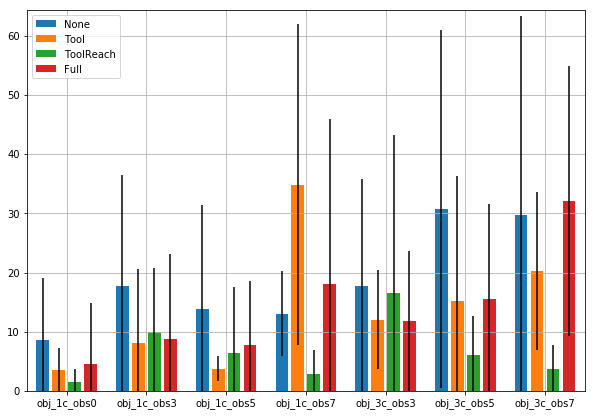

In [25]:
resdat_all, res_dict_all = print_results(RES_ROOT="stowing-deep-result", 
                                         RTYPE="indy7gripper", 
                                         DAT_DIR='20210907-173519',
                                         CNAMES_EXCLUDE=[], read_only=True
                                        )
plot_times(res_dict_all,
           CHECKERS=['None', 'Tool', 'ToolReach', 'Full'], 
           CASES=['obj_1c_obs0', 'obj_1c_obs3', 'obj_1c_obs5', 'obj_1c_obs7', 'obj_3c_obs3', 'obj_3c_obs5', 'obj_3c_obs7'], 
           all_points=False)

RES_ROOT: stowing-deep-result-all-before-ik-cyl-2(hot)
DAT_DIR: 20210907-173519
CNAME_LIST: ['None', 'Tool', 'ToolReach', 'Full']


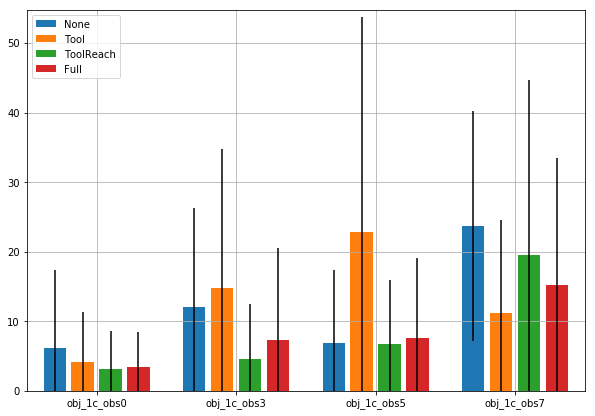

In [19]:
resdat_all, res_dict_all = print_results(RES_ROOT="stowing-deep-result-all-before-ik-cyl-2(hot)", 
                                         RTYPE="indy7gripper", 
                                         DAT_DIR='20210907-173519',
                                         CNAMES_EXCLUDE=[], read_only=True
                                        )
plot_times(res_dict_all,
           CHECKERS=['None', 'Tool', 'ToolReach', 'Full'], 
           CASES=['obj_1c_obs0', 'obj_1c_obs3', 'obj_1c_obs5', 'obj_1c_obs7'], all_points=False)

RES_ROOT: stowing-deep-result-all-before-ik-cyl
DAT_DIR: 20210907-173519
CNAME_LIST: ['None', 'Tool', 'ToolReach', 'Full']


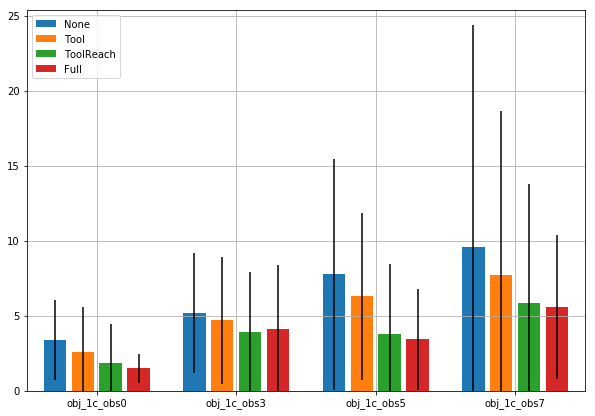

In [49]:
resdat_all, res_dict_all = print_results(RES_ROOT="stowing-deep-result-all-before-ik-cyl", 
                                         RTYPE="indy7gripper", 
                                         DAT_DIR='20210907-173519',
                                         CNAMES_EXCLUDE=[], read_only=True
                                        )
plot_times(res_dict_all,
           CHECKERS=['None', 'Tool', 'ToolReach', 'Full'], 
           CASES=['obj_1c_obs0', 'obj_1c_obs3', 'obj_1c_obs5', 'obj_1c_obs7'], all_points=False)

### 분석
* IK 예측 적용 후 불안정성이 생김. Tool보다 ToolReach가 안좋은 경향이 일관되게 발생
  - IK 학습 당시 조인트 리밋 체크: 정확도 체크 결과 풀조인트 확실
  - MP 학습 당시 조인트 리밋 체크: 데이터 수집 당시 (2월) 풀조인트 확실
  - Full 케이스에서도 IK 배제한다면? 별로..
* 선택지 부족으로 불가능해지는 (IK) 시나리오 최소화 필요
  - 실린더 물체 다수 + 장애물 다수로 기본 시나리오 체크: 불안정성은 감소, 단 효과가 여전히 없음
  - 실린더 물체 + Step3IK로 다시 시도: 결과 괜찮음
  - 단일 물체 + 1스켈레톤으로 시도: 결과 나쁨
  - 샘플 수 등 조정 (불안정 등이 이슈가 될 때)

## Step123-IK, Step3-MP
```
==================================================
RES_ROOT: stowing-deep-result
DAT_DIR: 20210907-173519
CNAME_LIST: ['None', 'Tool', 'ToolReach', 'Full']
==================================================
obj_1
obj_1_obs3
obj_1_obs5
obj_3
obj_3_pole
obj_3_hard
obj_1c_obs0
None files: 40
Tool files: 40
ToolReach files: 40
Full files: 40
================================================== obj_1c_obs0 ================================================== valid=39
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :     3.41      5.0     3.13     3.13(100.0)      0.1( 2.44)    12.33    12.33(100.0)     9.59(65.95)      0.0       40
Tool      :     2.62      5.0     3.31     3.31(100.0)     0.18(  3.6)     10.9     5.59(67.69)     2.74(35.98)      2.5       40
ToolReach :     1.87      5.0     3.33     3.33(100.0)     0.21( 3.89)    12.44     3.97(47.45)     1.05(19.82)      0.0       40
Full      :     1.51      5.0     3.05     3.05(100.0)     0.03( 0.51)    12.69     3.59(40.02)     0.67(13.14)      0.0       40
obj_1c_obs3
None files: 40
Tool files: 40
ToolReach files: 40
Full files: 40
================================================== obj_1c_obs3 ================================================== valid=34
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :     5.18      5.0     3.35     3.35(100.0)     0.32( 7.65)    13.38    13.38(100.0)    10.24( 67.1)     12.5       40
Tool      :      4.7      5.0     3.71     3.71(100.0)     0.53(10.01)    14.26     6.91(59.92)     3.56(38.16)      5.0       40
ToolReach :     3.94      5.0     3.68     3.68(100.0)      0.5( 9.66)    20.32     5.59(37.05)     1.97(28.16)      5.0       40
Full      :     4.11      5.0     3.47     3.47(100.0)     0.38(  7.4)    16.41     4.38(36.82)     1.12(20.03)      7.5       40
obj_1c_obs5
None files: 40
Tool files: 40
ToolReach files: 40
Full files: 40
================================================== obj_1c_obs5 ================================================== valid=32
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :     7.78      5.0     3.84     3.84(100.0)     0.53( 9.84)    23.22    23.22(100.0)    19.75(71.65)     20.0       40
Tool      :      6.3      5.0     3.62     3.62(100.0)     0.53( 9.67)    25.97    11.44(56.16)     8.06(58.94)     10.0       40
ToolReach :     3.77      5.0      3.5      3.5(100.0)     0.34( 6.15)    22.75     6.53(38.78)     3.47(28.97)     12.5       40
Full      :     3.43      5.0     3.34     3.34(100.0)     0.28( 6.04)    16.06     3.78(36.45)      1.0(18.54)     10.0       40
obj_1c_obs7
None files: 40
Tool files: 40
ToolReach files: 40
Full files: 40
================================================== obj_1c_obs7 ================================================== valid=35
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :     9.57      5.0     3.77     3.77(100.0)     0.63( 9.05)    22.34    22.34(100.0)     18.6(72.78)      7.5       40
Tool      :     7.74     5.11     4.09     4.09(100.0)     0.69(11.47)    19.94      9.8(60.03)     5.86(46.18)      7.5       40
ToolReach :     5.89      5.0     4.03     4.03(100.0)     0.71(10.45)    15.34     4.94( 44.0)     1.43(20.83)     10.0       40
Full      :     5.57      5.0     3.51     3.49(99.43)     0.34( 6.48)    22.51     5.11(43.78)      1.6(23.38)     10.0       40
obj_3c_obs3
None files: 40
Tool files: 40
ToolReach files: 40
Full files: 40
================================================== obj_3c_obs3 ================================================== valid=35
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :     13.0      5.0     3.71     3.71(100.0)     0.46( 8.33)    48.89    48.89(100.0)    40.69(73.66)     10.0       40
Tool      :     6.31      5.0      3.8      3.8(100.0)     0.51(  8.7)    32.34     13.0( 55.2)     7.34(46.35)      5.0       40
ToolReach :     3.71      5.0     3.26     3.26(100.0)     0.17( 3.52)    73.29     18.6(38.63)     7.03(26.81)      2.5       40
Full      :     5.05      5.0     3.66     3.57(98.14)      0.4( 8.03)    29.11     6.91(37.47)     1.83(23.17)      5.0       40
obj_3c_obs5
None files: 40
Tool files: 40
ToolReach files: 40
Full files: 40
================================================== obj_3c_obs5 ================================================== valid=30
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :     7.19      5.0     3.33     3.33(100.0)     0.27( 5.61)    22.97    22.97(100.0)     18.1(58.98)     22.5       40
Tool      :     7.95      5.0     3.87     3.87(100.0)     0.67( 9.85)     62.7     24.4(54.18)    14.27(48.68)     20.0       40
ToolReach :     7.53     5.07      4.0      4.0(100.0)      0.8(10.47)    73.83    23.33(41.32)    10.47(30.06)     17.5       40
Full      :     5.05      5.0     3.33     3.33(100.0)      0.3( 6.17)     42.7    10.03(33.26)     2.37(22.21)     17.5       40
obj_3c_obs7
None files: 40
Tool files: 40
ToolReach files: 40
Full files: 40
================================================== obj_3c_obs7 ================================================== valid=32
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :    10.44      5.0     3.56     3.56(100.0)     0.38( 7.51)    41.31    41.31(100.0)    34.94(69.99)     17.5       40
Tool      :     6.09      5.0     3.75     3.75(100.0)     0.53( 9.28)    33.16     12.5(52.89)     6.31(40.37)     17.5       40
ToolReach :     6.91      5.0     3.94     3.94(100.0)     0.75(13.38)    42.59    11.75(40.89)     5.31(28.56)     12.5       40
Full      :     6.68      5.0     3.66     3.66(100.0)     0.47( 9.43)    45.38    10.84(32.94)     3.16(22.81)     17.5       40
```

## Step12-IK, Step3-MP
```
==================================================
RES_ROOT: stowing-deep-result
DAT_DIR: 20210907-173519
CNAME_LIST: ['None', 'Tool', 'ToolReach', 'Full']
==================================================
obj_1
None files: 20
Tool files: 20
ToolReach files: 20
Full files: 20
================================================== obj_1      ================================================== valid=20
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :     5.11      5.0      3.0      3.0(100.0)      0.0(  0.0)     23.5     23.5(100.0)    19.65(67.69)      0.0       20
Tool      :     2.06      5.0     3.05     3.05(100.0)     0.05( 1.25)    36.55      8.7(40.31)      4.5(32.25)      0.0       20
ToolReach :     1.22      5.0      3.0      3.0(100.0)      0.0(  0.0)     31.7      4.9( 27.6)     0.75( 10.9)      0.0       20
Full      :     1.61      5.0     3.45     3.15(94.25)      0.0(  0.0)     47.2     6.55(20.83)      1.3(10.33)      0.0       20
obj_1_obs3
None files: 20
Tool files: 20
ToolReach files: 20
Full files: 20
================================================== obj_1_obs3 ================================================== valid=18
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :    10.28     5.25     3.88     3.88(100.0)     0.19( 3.26)    43.62    43.62(100.0)    37.94(70.22)     20.0       20
Tool      :     4.27      5.0      3.5      3.5(100.0)     0.33( 5.53)    49.56     8.56(39.18)     3.67(37.53)      5.0       20
ToolReach :     5.82      5.0     3.72     3.72(100.0)     0.61(  9.2)    68.17     9.83(21.23)     3.28( 28.2)      5.0       20
Full      :     2.76      5.0     3.33     3.28(98.89)     0.28( 6.94)    44.33     6.33(28.53)     1.33(18.67)      5.0       20
obj_1_obs5
None files: 20
Tool files: 20
ToolReach files: 20
Full files: 20
================================================== obj_1_obs5 ================================================== valid=15
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :    11.41     5.27      3.4      3.4(100.0)      0.2( 3.24)     33.0     33.0(100.0)    28.73(81.83)     25.0       20
Tool      :     3.68      5.0     3.27     3.27(100.0)     0.27(  6.0)    36.33     8.93(34.58)     4.93( 45.2)      0.0       20
ToolReach :      4.3     5.27      3.6      3.6(100.0)     0.33( 5.33)   123.53     11.8(22.56)      4.4(24.69)     20.0       20
Full      :     4.72      5.0     3.87     3.67(97.69)      0.4(  6.1)    41.13     8.27(29.69)      3.4(24.85)     15.0       20
obj_3
None files: 20
Tool files: 20
ToolReach files: 20
Full files: 20
================================================== obj_3      ================================================== valid=17
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :    14.31      5.0     3.61     3.61(100.0)     0.39( 5.83)    60.83    60.83(100.0)    53.22(74.29)     10.0       20
Tool      :     2.04      5.0     3.06     3.06(100.0)     0.06( 1.47)    31.94     8.35(37.54)     3.53(28.12)      5.0       20
ToolReach :     2.12      5.0     3.18     3.18(100.0)     0.18( 2.94)     82.0     9.12(30.76)     2.06(12.85)     10.0       20
Full      :     1.71      5.0     3.06      3.0(98.53)      0.0(  0.0)    53.29     6.47(20.09)     1.88( 18.3)     10.0       20
obj_3_pole
None files: 20
Tool files: 20
ToolReach files: 20
Full files: 20
================================================== obj_3_pole ================================================== valid=12
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :    23.29      5.0      3.6      3.6(100.0)      0.3( 6.17)    126.4    126.4(100.0)    119.6(86.99)     50.0       20
Tool      :     6.21      5.0     3.67     3.67(100.0)     0.42( 7.04)   166.33    17.92(30.77)    11.42(61.86)     30.0       20
ToolReach :    21.89     5.67     8.17     8.17(100.0)     2.17(13.91)   354.67    40.08(15.49)    24.67(45.06)     20.0       20
Full      :     6.26      5.0      4.5     4.17(95.69)     0.67(10.51)   200.08    24.83(21.24)    15.17( 45.9)     20.0       20
obj_3_hard
None files: 20
Tool files: 20
ToolReach files: 20
Full files: 20
================================================== obj_3_hard ================================================== valid=7
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :    17.48      5.4      3.7      3.7(100.0)      0.3( 5.33)    101.1    101.1(100.0)     83.7(69.07)     50.0       20
Tool      :     7.45      5.0      3.0      3.0(100.0)      0.0(  0.0)     52.0     33.0(64.49)    24.14(57.72)     45.0       20
ToolReach :     3.81      5.0     3.14     3.14(100.0)     0.14( 3.57)     69.0    18.43( 29.5)     6.29(27.53)     45.0       20
Full      :     9.82      5.0     4.57     4.57(100.0)     0.71(10.37)   219.86    78.71(40.36)    34.14(31.15)     55.0       20
obj_1c_obs3
None files: 40
Tool files: 40
ToolReach files: 40
Full files: 40
================================================== obj_1c_obs3 ================================================== valid=36
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :     5.72      5.0     3.78     3.78(100.0)     0.51( 9.65)    14.24    14.24(100.0)     10.7(65.91)      7.5       40
Tool      :     2.66      5.0     3.14     3.14(100.0)     0.11( 2.64)    12.08     6.67(67.35)     4.06(44.45)      5.0       40
ToolReach :     2.79      5.0     3.42     3.42(100.0)     0.31( 6.77)    14.25     4.11(40.88)     1.17(19.45)     10.0       40
Full      :     3.55      5.0     3.53     3.39(97.05)     0.28( 5.49)    15.08     5.42(52.41)     2.19(28.24)      5.0       40
obj_3c_obs3
None files: 40
Tool files: 40
ToolReach files: 40
Full files: 40
================================================== obj_3c_obs3 ================================================== valid=37
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :    10.24      5.0      3.7      3.7(100.0)     0.49( 8.56)    37.81    37.81(100.0)    31.14(73.86)      7.5       40
Tool      :     5.64      5.0     3.59     3.59(100.0)     0.46( 8.63)    52.51    17.76(48.91)    10.76(48.68)      2.5       40
ToolReach :     7.16      5.0     4.16     4.16(100.0)     0.81(13.87)    90.76    21.65(41.52)    11.78(33.64)      5.0       40
Full      :     7.22     5.22     4.51     4.08(94.01)     0.57(  9.9)   100.59    23.59( 33.6)    14.54(30.46)      5.0       40
obj_3c_obs5
None files: 40
Tool files: 40
ToolReach files: 40
Full files: 40
================================================== obj_3c_obs5 ================================================== valid=31
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :    10.84      5.0     3.77     3.77(100.0)     0.55( 8.84)    35.58    35.58(100.0)    28.87(73.87)     22.5       40
Tool      :     7.94      5.0     3.97     3.97(100.0)     0.81(14.75)    52.48    19.03( 49.8)    10.48(48.26)     20.0       40
ToolReach :     4.62      5.0     3.65     3.65(100.0)     0.42( 8.26)    50.55    13.32( 37.5)     4.61(32.14)     17.5       40
Full      :     4.56      5.0     3.97     3.81(97.33)     0.39( 7.18)    34.87    10.03(38.38)     3.61(23.97)     15.0       40
```

In [55]:
resdat_all, res_dict_all = print_results(RES_ROOT="stowing-deep-result", 
                                         RTYPE="indy7gripper", 
                                         DAT_DIR='20210907-173519', read_only=True)
print_debug_info(resdat_all)

RES_ROOT: stowing-deep-result
DAT_DIR: 20210907-173519
CNAME_LIST: ['None', 'Tool', 'ToolReach', 'Full']
============== Checker Results ===============
---------- obj_1      ----------
              accuracy  precision     recall
Full      :    91.18 %    93.94 %    96.88 %
---------- obj_1_obs3 ----------
              accuracy  precision     recall
Full      :    89.06 %     91.8 %    96.55 %
---------- obj_1_obs5 ----------
              accuracy  precision     recall
Full      :    82.61 %    85.71 %    92.31 %
---------- obj_3      ----------
              accuracy  precision     recall
Full      :    94.55 %    98.11 %     96.3 %
---------- obj_3_pole ----------
              accuracy  precision     recall
Full      :    86.54 %     90.0 %    92.31 %
---------- obj_3_hard ----------
              accuracy  precision     recall

=============== Cache Check ==================
---------- obj_1      ----------
              accuracy  precision     recall
Full      :    100.0 %    100

In [56]:
res_dict_all['obj_3_pole']['Full'][17]

[27.598180055618286, 5, 4, 4, 1, 87, 87, 78, True]

In [57]:
resdat = resdat_all['obj_3_pole']['Full'][17]

In [58]:
resdat['cache_log']

[(False, True), (True, True)]

In [46]:
resdat = resdat_all['obj_3_pole']['Full'][0]

In [47]:
resdat['body_names']

{1L: 'obj_0',
 2L: 'gp',
 3L: 'wp_bot',
 4L: 'obj_1',
 5L: 'floor',
 6L: 'pole',
 7L: 'base',
 8L: 'wp',
 9L: 'gp_bot',
 10L: 'obj_2'}

In [50]:
resdat['checker_ik']

['GraspChecker', 'ReachChecker']

In [48]:
resdat['checkers_mp']

['LatticedChecker']

=== obj_1 ===
Full
average accuracy: 100.0
=== obj_1_obs3 ===
Full
14 - 0: GraspChecker / success
16 - 83: Success / approach_motion
average accuracy: 99.91
=== obj_1_obs5 ===
Full
3 - 54: Success / approach_motion
7 - 7: Success / approach_motion
12 - 210: Success / approach_motion
12 - 232: Success / approach_motion
12 - 350: Success / approach_motion
average accuracy: 99.86
=== obj_3 ===
Full
5 - 26: Success / approach_motion
5 - 170: Success / approach_motion
5 - 187: Success / approach_motion
average accuracy: 99.85
=== obj_3_hard ===
average accuracy: 99.85
=== obj_3_pole ===
Full
1 - 189: Success / approach_motion
5 - 4: Success / approach_motion
6 - 110: Success / approach_motion
6 - 551: Success / approach_motion
11 - 50: ReachChecker / success
average accuracy: 99.88


In [19]:
for i_d, dat in enumerate(dat_list):
    ik_feas_reason, ik_res_reason = dat['ik_feas_reason'], dat['ik_res_reason']
    for fres, rres in zip(ik_feas_reason, ik_res_reason):
        print("{} - {}".format(fres, rres))

ReachChecker - ik_approach
Success - col_approach
Success - success
GraspChecker - ik_approach
GraspChecker - ik_approach
GraspChecker - ik_approach
GraspChecker - ik_approach
ReachChecker - ik_approach
GraspChecker - ik_approach
Success - success
GraspChecker - ik_approach
GraspChecker - ik_approach
GraspChecker - ik_approach
GraspChecker - ik_approach
GraspChecker - ik_approach
GraspChecker - ik_approach
GraspChecker - ik_approach
Success - col_approach
GraspChecker - ik_approach
GraspChecker - ik_approach
ReachChecker - ik_approach
GraspChecker - ik_approach
GraspChecker - ik_approach
ReachChecker - ik_approach
GraspChecker - ik_approach
GraspChecker - ik_approach
ReachChecker - ik_approach
GraspChecker - ik_approach
GraspChecker - ik_approach
ReachChecker - ik_approach
GraspChecker - ik_approach
GraspChecker - ik_approach
ReachChecker - ik_approach
GraspChecker - ik_approach
GraspChecker - ik_approach
ReachChecker - ik_approach
GraspChecker - ik_approach
GraspChecker - ik_approach


average accuracy: 100.0


In [10]:
ik_feas_reason

['Success', 'Success']

In [11]:
ik_res_reason

['success', 'success']

In [ ]:
for ir, resdat in enumerate(resdat_all['obj_1_obs3']['Full']):
    if 'GraspChecker' in resdat:
        if not all(resdat['GraspChecker']):
            print('GraspChecker')
            break
    if 'ReachChecker' in resdat:
        if not all(resdat['ReachChecker']):
            print('ReachChecker')
            break

In [ ]:
ir

In [ ]:
resdat['GraspChecker']

In [ ]:
resdat

In [ ]:
cache_log = [np.array(dat['cache_log'])[:, 0] 
             if 'cache_log' in dat else []
             for dat in resdat_all['obj_1_obs3']['ToolReach']]

In [ ]:
cache_log

In [ ]:
dat['cache_log']

In [ ]:
resdat['GraspChecker']

In [ ]:
resdat['ReachChecker']

In [ ]:
resdat['LatticedChecker']

In [ ]:
resdat['pre_motion_checks']

In [ ]:
resdat['planning_log']

In [ ]:
all([all(dat['cache_log']) for dat in resdat_all['obj_1_obs3']['Full']])

In [ ]:
all([all(dat['cache_log']) for dat in resdat_all['obj_1_obs3']['Tool']])

In [ ]:
all([all(dat['cache_log']) for dat in resdat_all['obj_1_obs3']['ToolReach']])

In [ ]:
all([all(dat['cache_log']) for dat in resdat_all['obj_1_obs3']['None']])

In [ ]:
[(dat['cache_log']) for dat in resdat_all['obj_1_obs3']['Full']]

In [ ]:
res_dict = res_dict_all['obj_1_obs3']
cnames = ['Tool', 'ToolReach', 'Full']
idc_all = np.where(np.all([[res[-1] for rs in res_dict[cname]] for cname in cnames], axis=0))[0]

In [ ]:
for cname in cnames:
    times = [res_dict[cname][idc][0] for idc in idc_all]
    outnum = int(len(times)/5)
    print("{}: {}".format(cname, np.mean(sorted(times, key=lambda x:abs(x - np.mean(times)))[:-outnum])))

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(sorted(times, key=lambda x:abs(x - np.mean(times)))[:-outnum])

In [ ]:
np.mean(times)

In [ ]:
res_list = res_dict_all['obj_1_obs3']['ToolReach']
for i, res in enumerate(res_list):
    print("{:02}: {}".format(i, res))

In [ ]:
res_list = res_dict_all['obj_1_obs3']['Full']
for i, res in enumerate(res_list):
    print("{:02}: {}".format(i, res))

In [ ]:
res_list = res_dict_all['obj_3_hard']['Tool']
for i, res in enumerate(res_list):
    print("{:02}: {}".format(i, res))

In [ ]:
res_list = res_dict_all['obj_3_hard']['ToolReach']
for i, res in enumerate(res_list):
    print("{:02}: {}".format(i, res))

In [ ]:
np.where([res[0] < 99 and not res[-1] for res in res_dict_all['obj_3_None']['Full']])

#### checking error scenes

In [ ]:
from pkg.planning.motion.interface import MOTION_PATH
from pkg.planning.filtering.latticized_filter import SCENE_PATH

print("==== MOTION scene errors ====")
print(sorted([fname for fname in os.listdir(MOTION_PATH)]))
print("==== Lcheck scene errors ====")
print(sorted([fname for fname in os.listdir(SCENE_PATH) if "OK" not in fname]))

## No Step3 before IK
```
==================================================
RES_ROOT: stowing-deep-result-before-ik-only2
DAT_DIR: 20210906-125756
CNAME_LIST: ['None', 'Tool', 'ToolReach', 'Full']
==================================================
obj_1
None files: 20
Tool files: 20
ToolReach files: 20
Full files: 20
================================================== obj_1      ================================================== valid=20
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :    11.14      5.8     3.65     3.65(100.0)      0.1( 1.39)    32.15    32.15(100.0)    25.35(72.67)      0.0       20
Tool      :     1.53      5.0      3.0      3.0(100.0)      0.0(  0.0)     27.2      6.3(45.08)     2.35(32.21)      0.0       20
ToolReach :     1.59      5.2      3.6      3.5(98.17)     0.15( 2.92)    40.05      5.9(27.01)     0.95(12.56)      0.0       20
Full      :     1.86      5.0      3.7      3.6(98.17)     0.25( 5.33)     31.0      5.6(33.29)      0.9(12.58)      0.0       20
obj_3
None files: 20
Tool files: 20
ToolReach files: 20
Full files: 20
================================================== obj_3      ================================================== valid=18
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :    17.06     5.89     3.56     3.56(100.0)     0.11( 2.31)    81.78    81.78(100.0)    67.44(73.81)     10.0       20
Tool      :     3.67     5.22      3.5      3.5(100.0)     0.39( 4.63)    55.72    10.39(32.71)     2.72(28.16)     10.0       20
ToolReach :     1.78      5.0     3.06     3.06(100.0)     0.06( 1.39)    111.5    11.44( 22.3)     1.94(17.26)      5.0       20
Full      :     1.52      5.0     3.22     3.17(98.89)     0.06( 1.11)    95.11    11.61( 21.0)     2.17(17.21)      5.0       20
obj_3_pole
None files: 20
Tool files: 20
ToolReach files: 20
Full files: 20
================================================== obj_3_pole ================================================== valid=12
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :    25.51     5.86     4.29     4.29(100.0)      0.5( 7.22)   105.36   105.36(100.0)    87.07( 71.4)     30.0       20
Tool      :     6.37      5.5     3.83     3.83(100.0)     0.42( 6.88)    138.0    18.75(21.21)    11.58(55.84)     15.0       20
ToolReach :    14.07     5.67     5.58     5.58(100.0)     0.67( 4.95)   726.08    69.08(15.65)    39.17(41.31)     35.0       20
Full      :    16.88      6.0     7.58      6.5(93.98)      1.0( 9.38)   603.75     48.0(15.33)    23.58(38.36)     25.0       20
obj_3_hard
None files: 20
Tool files: 20
ToolReach files: 20
Full files: 20
================================================== obj_3_hard ================================================== valid=10
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :    23.25      6.0     4.75     4.75(100.0)     0.67( 7.87)     99.5     99.5(100.0)    75.75(77.61)     40.0       20
Tool      :    15.52      6.2      3.9      3.9(100.0)      0.2( 2.78)     57.6     34.3(56.47)     25.3( 60.6)     40.0       20
ToolReach :     5.36      5.4      3.4      3.4(100.0)      0.2( 4.17)    178.8     39.8(28.94)     14.8(45.59)     25.0       20
Full      :      8.7      5.4      4.4      4.0( 95.5)      0.1( 1.25)    336.6     71.7(24.08)     35.9(38.64)     25.0       20
```

## Full before IK
```
==================================================
RES_ROOT: stowing-deep-result
DAT_DIR: 20210906-125756
CNAME_LIST: ['None', 'Tool', 'ToolReach', 'Full']
==================================================
obj_1
None files: 10
Tool files: 10
ToolReach files: 10
Full files: 10
================================================== obj_1      ================================================== valid=10
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :     3.83      5.4      3.3      3.3(100.0)      0.1(  2.5)     12.7     12.7(100.0)      9.3(68.09)      0.0       10
Tool      :     3.28      5.4      3.6      3.5( 98.0)      0.1( 1.43)     29.5      9.8(54.47)      5.7(39.76)      0.0       10
ToolReach :     1.12      5.0      3.0      3.0(100.0)      0.0(  0.0)     21.2      4.8(38.15)      1.2(18.62)      0.0       10
Full      :     2.66      5.0      3.3      3.2( 98.0)      0.1(  2.5)     67.5      6.0(24.73)      1.1(14.31)      0.0       10
obj_3
None files: 10
Tool files: 10
ToolReach files: 10
Full files: 10
================================================== obj_3      ================================================== valid=9
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :     8.36     5.44     3.33     3.33(100.0)     0.11( 2.78)    35.56    35.56(100.0)    27.78(75.88)     10.0       10
Tool      :     2.71      5.0     3.22     3.22(100.0)     0.11( 2.22)     81.0    14.67(35.09)     4.56( 18.7)     10.0       10
ToolReach :     4.23     5.67     3.67     3.67(100.0)     0.33( 6.48)   201.56    30.89(32.25)      5.0(17.26)     10.0       10
Full      :     3.98      5.0     3.56     3.44(98.15)     0.11( 2.22)   158.89    18.11( 19.0)      2.0(11.21)     10.0       10
obj_3_pole
None files: 10
Tool files: 10
ToolReach files: 10
Full files: 10
================================================== obj_3_pole ================================================== valid=8
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :    27.07      8.0     6.12     6.12(100.0)      0.5( 6.58)   117.75   117.75(100.0)    92.62(79.86)     20.0       10
Tool      :    15.43      6.5     7.62      7.5(99.22)      1.0( 8.52)   513.12    59.88( 20.3)    38.62(51.82)     20.0       10
ToolReach :    11.07      5.0     5.62      5.5(97.92)      1.0( 8.33)    274.0     31.0( 19.2)     20.0(52.52)     10.0       10
Full      :    13.51      5.5     6.88     6.75(99.04)     0.88( 4.17)   367.38     24.5(20.91)     7.38(21.67)     20.0       10
obj_3_hard
None files: 10
Tool files: 10
ToolReach files: 10
Full files: 10
================================================== obj_3_hard ================================================== valid=3
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :    34.78      6.0     6.88     6.88(100.0)     0.75(  6.3)   148.88   148.88(100.0)    126.5( 76.6)     20.0       10
Tool      :      9.2      5.0      3.0      3.0(100.0)      0.0(  0.0)    40.67    30.67(70.14)    26.33(79.12)     50.0       10
ToolReach :     1.95      5.0      3.0      3.0(100.0)      0.0(  0.0)     22.0      7.0(33.82)     4.67(66.87)     30.0       10
Full      :    34.88      5.0     8.67     8.67(100.0)     1.33(12.22)    236.0     35.0( 21.0)     8.67(27.09)     40.0       10
```

### Indy Result bak: no step 3 before IK, angle, pole distance added, place sample limit, no appraoch
```
============================== obj_1      ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     valid=48
None      : 12.28      5.52       3.46       3.43       0.11       33.96      33.96      27.07      4          50        
Tool      : 5.35       5.08       3.21       3.17       0.04       48.73      10.23      5.25       1          50        
ToolReach : 5.7        5.08       3.54       3.52       0.23       37.12      6.67       1.58       1          50        
Full      : 4.61       5.0        3.67       3.44       0.06       24.98      6.25       1.81       2          50        
============================== obj_3      ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     valid=47
None      : 26.37      6.19       4.02       4.02       0.09       101.7      101.7      87.87      3          50        
Tool      : 9.7        5.68       4.17       4.04       0.06       256.21     42.11      20.74      2          50        
ToolReach : 5.36       5.09       3.3        3.23       0.04       227.15     22.28      5.51       2          50        
Full      : 6.15       5.17       3.64       3.47       0.06       181.26     20.87      6.55       0          50        
============================== obj_3_pole ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     valid=42
None      : 32.37      5.65       3.97       3.92       0.3        113.19     113.19     102.27     13         50        
Tool      : 15.37      5.19       3.88       3.83       0.48       442.57     55.02      36.81      5          50        
ToolReach : 12.89      5.52       5.62       5.45       0.64       452.29     51.55      29.36      4          50        
Full      : 11.04      5.0        5.62       4.95       0.4        309.21     32.4       19.4       4          50              
```

### Indy Result bak: No step 3 before IK, angle, pole distance added
```
============================== obj_3_pole ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
None      : 24.31      6.56       3.78       3.78       0.0        55.67      55.67      50.72      22         40        
Tool      : 24.46      6.52       3.86       3.86       0.05       188.05     55.81      37.0       10         39        
ToolReach : 19.37      5.19       3.24       3.24       0.05       360.81     47.0       28.0       11         39        
Full      : 15.9       5.9        3.62       3.62       0.1        274.71     25.1       14.81      12         39        
============================== obj_3_pole-hard ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
Tool      : 36.2       7.0        4.0        4.0        0.0        289.08     83.83      56.08      10         30        
ToolReach : 27.5       5.0        3.0        3.0        0.0        522.75     73.42      44.17      11         30        
Full      : 19.3       5.92       3.5        3.5        0.08       385.33     32.17      20.08      12         30   
```

### Indy Result bak: No step 3 before IK
```
============================== obj_1      ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
None      : 13.82      6.75       4.04       3.94       0.0        39.35      39.35      31.31      2          50        
Tool      : 9.25       6.17       3.71       3.65       0.02       41.06      16.5       9.04       1          50        
ToolReach : 3.78       5.92       3.46       3.46       0.0        35.44      9.46       2.21       0          50        
Full      : 4.09       5.5        4.1        3.98       0.17       36.56      7.67       1.92       1          50        
============================== obj_1-hard ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
Tool      : 11.72      6.12       3.75       3.66       0.03       52.69      20.41      11.62      1          34        
ToolReach : 4.33       6.38       3.69       3.69       0.0        45.22      12.28      3.03       0          34        
Full      : 4.41       5.38       4.47       4.28       0.25       34.5       8.22       2.0        1          34        
============================== obj_3      ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
None      : 23.15      7.64       4.82       4.7        0.09       67.16      67.16      54.48      6          50        
Tool      : 14.9       6.55       3.95       3.91       0.02       162.43     34.95      16.36      6          50        
ToolReach : 7.15       6.14       3.8        3.8        0.16       89.45      14.34      4.2        2          50        
Full      : 10.41      5.89       5.86       5.05       0.02       211.61     30.91      9.91       4          50        
============================== obj_3-hard ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
Tool      : 21.16      7.15       4.38       4.31       0.04       219.08     50.0       24.15      6          32        
ToolReach : 9.4        6.77       4.27       4.27       0.27       107.96     19.5       5.19       2          32        
Full      : 14.94      6.5        7.85       6.46       0.04       312.77     47.27      15.12      4          32        
============================== obj_3_pole ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
None      : 42.18      7.44       4.71       4.68       0.06       121.74     121.74     108.65     16         50        
Tool      : 15.32      6.0        4.34       4.34       0.47       182.56     22.31      12.47      9          50        
ToolReach : 20.23      6.62       4.56       4.56       0.25       458.78     45.44      18.47      5          50        
Full      : 12.32      5.75       4.06       4.03       0.22       416.84     32.78      15.0       10         50        
============================== obj_3_pole-hard ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
Tool      : 16.81      6.09       4.5        4.5        0.59       180.68     24.32      14.05      9          40        
ToolReach : 25.86      6.82       4.91       4.91       0.32       604.05     60.5       24.91      5          40        
Full      : 13.2       5.91       4.36       4.32       0.27       391.82     34.91      14.91      10         40    
```

### Indy Result bak: full filter before IK (MP_tot wrong)
```
============================== obj_1      ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
None      : 12.63      7.29       4.33       4.33       0.04       45.12      45.12      34.71      2          50        
Tool      : 9.59       6.36       3.83       3.83       0.06       52.09      21.55      12.0       1          50        
ToolReach : 7.72       5.26       3.19       3.19       0.02       23.74      4.6        0.81       0          50        
Full      : 7.96       6.02       3.53       3.53       0.0        36.02      7.55       1.89       3          50        
============================== obj_1-hard ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
Tool      : 14.3       7.0        4.27       4.27       0.12       79.77      32.77      18.77      1          29        
ToolReach : 11.86      5.46       3.35       3.35       0.04       24.73      4.96       1.0        0          29        
Full      : 11.15      5.92       3.46       3.46       0.0        48.15      9.15       2.65       3          29        
============================== obj_3      ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
None      : 19.07      7.05       4.03       4.03       0.0        54.23      54.23      42.62      11         50        
Tool      : 13.64      6.73       4.03       4.03       0.03       162.86     30.41      13.84      8          50        
ToolReach : 6.59       6.05       3.57       3.57       0.05       88.7       12.57      3.73       4          50        
Full      : 11.39      6.73       3.97       3.97       0.03       86.38      15.22      4.03       6          49        
============================== obj_3-hard ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
Tool      : 24.54      7.86       4.5        4.5        0.0        362.07     60.86      28.93      8          26        
ToolReach : 10.86      6.71       3.86       3.86       0.0        183.21     23.21      7.29       4          26        
Full      : 16.57      7.0        4.07       4.07       0.0        154.36     23.29      5.79       6          26        
============================== obj_3_pole ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
None      : 36.2       7.91       5.59       5.59       0.21       99.12      99.12      86.56      16         50        
Tool      : 16.99      6.03       4.05       4.05       0.21       292.29     35.89      21.45      9          50        
ToolReach : 16.52      6.05       3.76       3.76       0.08       512.53     39.05      19.95      5          50        
Full      : 18.31      6.79       4.0        4.0        0.03       188.82     28.53      8.32       7          50        
============================== obj_3_pole-hard ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
Tool      : 19.04      6.22       4.22       4.22       0.17       275.74     40.87      25.39      9          35        
ToolReach : 22.48      6.22       3.65       3.65       0.04       705.13     50.52      27.7       5          35        
Full      : 23.77      7.26       4.3        4.3        0.04       259.78     39.09      11.3       7          35     
```

### Panda Result bak: full filter before IK (MP_tot wrong)
```
============================== obj_1      ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
None      : 14.65      6.7        3.94       3.94       0.04       54.79      54.79      40.77      3          50        
Tool      : 10.45      6.77       4.32       4.32       0.11       56.4       21.47      11.34      1          50        
ToolReach : 7.82       5.85       4.23       4.23       0.15       77.91      16.68      4.96       1          50        
Full      : 8.01       6.53       3.94       3.94       0.06       71.89      20.91      6.6        1          50        
============================== obj_1-hard ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
Tool      : 13.59      7.58       4.81       4.81       0.1        70.32      27.48      14.35      1          34        
ToolReach : 10.23      5.9        4.48       4.48       0.16       97.19      21.39      6.68       1          34        
Full      : 10.42      6.81       4.16       4.16       0.1        94.29      28.13      8.97       1          34        
============================== obj_3      ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
None      : 23.29      7.25       5.0        5.0        0.16       81.18      81.18      69.98      6          50        
Tool      : 12.71      6.4        4.09       4.09       0.09       138.07     29.67      15.65      5          50        
ToolReach : 6.86       6.47       3.86       3.86       0.07       200.07     25.26      10.81      3          50        
Full      : 10.31      6.4        4.12       4.12       0.09       131.4      20.47      6.93       4          50        
============================== obj_3-hard ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
Tool      : 22.92      6.78       4.67       4.67       0.17       251.28     51.89      28.72      5          25        
ToolReach : 10.08      6.33       3.67       3.67       0.0        343.33     38.39      17.56      3          25        
Full      : 17.25      6.78       4.89       4.89       0.22       195.0      30.72      10.61      4          25        
============================== obj_3_pole ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
None      : 31.73      5.0        3.0        3.0        0.0        221.0      221.0      216.0      10         13        
Tool      : 16.91      9.0        5.0        5.0        0.0        358.0      65.0       38.0       8          13        
ToolReach : 6.26       9.0        5.0        5.0        0.0        262.0      34.0       17.0       4          13        
Full      : 17.74      5.0        3.0        3.0        0.0        2377.0     30.0       11.0       5          12        
============================== obj_3_pole-hard ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
Tool      : 16.91      9.0        5.0        5.0        0.0        358.0      65.0       38.0       8          12        
ToolReach : 6.26       9.0        5.0        5.0        0.0        262.0      34.0       17.0       4          12        
Full      : 17.74      5.0        3.0        3.0        0.0        2377.0     30.0       11.0       5          12       
```

### Panda Result bak: full filter before IK, sampling 5
```
============================== obj_3      ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
None      : 19.32      7.05       4.93       4.93       0.21       76.79      76.79      65.3       5          48        
Tool      : 6.93       5.64       3.32       3.32       0.0        218.5      33.55      15.27      1          48        
ToolReach : 5.65       5.27       3.25       3.23       0.05       260.36     33.41      13.8       3          48        
Full      : 10.26      6.0        4.16       4.16       0.14       350.45     39.45      15.89      1          48        
============================== obj_3-hard ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
Tool      : 11.0       6.4        3.7        3.7        0.0        395.9      62.3       28.45      1          24        
ToolReach : 8.23       5.4        3.2        3.2        0.0        452.05     60.65      24.4       3          24        
Full      : 17.96      6.6        5.25       5.25       0.3        682.35     75.0       31.7       1          24    
```

### Panda Result bak: no step 3 before IK, sampling 10
```
============================== obj_1      ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
None      : 15.21      6.17       4.02       4.02       0.19       61.51      61.51      49.28      3          50        
Tool      : 4.23       5.08       3.06       3.06       0.02       61.7       9.32       4.84       0          50        
ToolReach : 2.86       5.08       3.2        3.2        0.1        54.64      7.02       2.24       0          50        
Full      : 3.84       5.24       3.42       3.42       0.16       38.4       6.48       2.08       0          50        
============================== obj_1-hard ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
Tool      : 5.18       5.12       3.09       3.09       0.03       82.81      11.09      5.97       0          32        
ToolReach : 3.32       5.12       3.31       3.31       0.16       72.66      8.38       2.91       0          32        
Full      : 4.76       5.38       3.66       3.66       0.25       41.75      7.38       2.59       0          32        
============================== obj_3      ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
None      : 16.45      6.6        3.8        3.8        0.0        89.3       89.3       76.6       2          22        
Tool      : 10.51      6.2        5.3        5.3        0.55       240.0      48.9       21.45      1          22        
ToolReach : 3.37       5.0        3.15       3.15       0.05       118.0      12.4       6.15       1          22        
Full      : 3.81       5.2        3.25       3.25       0.1        118.35     12.1       5.05       2          22        
============================== obj_3-hard ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
Tool      : 21.12      7.86       9.0        9.0        1.43       517.86     108.43     45.14      1          9         
ToolReach : 4.03       5.0        3.43       3.43       0.14       169.0      16.71      10.14      1          9         
Full      : 5.27       5.57       3.71       3.71       0.29       162.57     18.71      6.86       2          9        
```

## Res - panda
```

```

## Res - indy7
```
============================== obj_1           ==============================
Checker        : Planning time   Motion count    MP trials       Failed MP       Failures        Total          
None           : 7.2             5.8             3.4             0.0             0               10             
Tool           : 7.83            6.5             4.5             0.3             0               10             
ToolReach      : 3.55            5.8             4.2             0.3             0               10             
Full           : 1.94            5.4             3.2             0.0             0               10             
 
============================== obj_3           ==============================
Checker        : Planning time   Motion count    MP trials       Failed MP       Failures        Total          
None           : 23.27           8.11            4.56            0.0             1               10             
Tool           : 11.77           5.5             6.12            0.12            2               10             
ToolReach      : 5.02            5.57            9.0             0.0             3               10             
Full           : 6.66            5.44            3.56            0.0             1               10             
 
============================== obj_3_pole      ==============================
Checker        : Planning time   Motion count    MP trials       Failed MP       Failures        Total          
None           : 48.29           9.0             5.0             0.0             4               10             
Tool           : 15.81           6.0             11.75           1.12            2               10             
ToolReach      : 31.28           7.0             14.67           1.17            4               10             
Full           : 15.32           5.0             5.0             0.0             5               10            
```

## Res - indy7 - new
```
============================== obj_1      ==============================
Checker   : Plan time  Actions    MPs        MP fails   IKs        IK fails   Failures   Total     
None      : 11.62      6.53       3.87       0.04       38.17      30.3       3          50        
Tool      : 7.75       5.9        4.75       0.33       24.0       12.96      2          50        
ToolReach : 3.13       5.17       3.19       0.06       6.12       1.67       0          50        
Full      : 2.29       5.58       3.54       0.1        8.1        2.06       0          50        
============================== obj_1-hard ==============================
Checker   : Plan time  Actions    MPs        MP fails   IKs        IK fails   Failures   Total     
Tool      : 14.99      6.05       6.68       0.74       45.53      24.42      0          19        
ToolReach : 5.81       5.42       3.47       0.16       6.84       1.63       0          19        
Full      : 3.41       6.05       4.0        0.21       11.05      2.16       0          19        
============================== obj_3      ==============================
Checker   : Plan time  Actions    MPs        MP fails   IKs        IK fails   Failures   Total     
None      : 19.86      7.19       4.34       0.08       61.74      50.17      8          61        
Tool      : 10.1       6.84       4.2        0.1        30.48      16.24      8          61        
ToolReach : 5.66       6.2        3.78       0.08       25.04      7.42       5          61        
Full      : 6.07       6.08       4.02       0.1        22.0       6.5        6          61        
============================== obj_3-hard ==============================
Checker   : Plan time  Actions    MPs        MP fails   IKs        IK fails   Failures   Total     
Tool      : 26.22      9.0        6.0        0.17       83.83      50.33      0          6         
ToolReach : 15.82      7.0        4.0        0.0        65.33      18.17      0          6         
Full      : 13.71      6.33       6.0        0.17       59.83      17.67      0          6         
============================== obj_3_pole ==============================
Checker   : Plan time  Actions    MPs        MP fails   IKs        IK fails   Failures   Total     
None      : 32.5       7.15       5.55       0.61       114.12     100.67     17         50        
Tool      : 19.07      5.84       5.19       0.51       44.76      25.49      10         50        
ToolReach : 14.79      5.97       5.97       0.65       51.27      20.22      5          50        
Full      : 10.58      6.03       6.81       0.76       38.32      17.24      8          50        
============================== obj_3_pole-hard ==============================
Checker   : Plan time  Actions    MPs        MP fails   IKs        IK fails   Failures   Total     
Tool      : 34.47      7.4        4.2        0.0        61.6       29.2       0          5         
ToolReach : 47.08      6.6        3.8        0.0        199.4      74.8       0          5         
Full      : 22.43      7.2        12.2       1.8        83.2       37.2       0          5        
```

In [ ]:
from __future__ import print_function
import os
RNB_PLANNING_DIR = os.environ["RNB_PLANNING_DIR"]
os.chdir(os.path.join(RNB_PLANNING_DIR, 'src'))
from pkg.controller.combined_robot import *
from pkg.utils.utils import get_now, try_mkdir
import subprocess

DATA_PATH = os.path.join(RNB_PLANNING_DIR, "data")
try_mkdir(DATA_PATH)

DAT_ROOT = "stowing-deep"
RES_ROOT = "stowing-deep-result"

TEST_DATA_PATH = os.path.join(DATA_PATH, DAT_ROOT)
try_mkdir(TEST_DATA_PATH)

TEST_RESULT_PATH = os.path.join(DATA_PATH, RES_ROOT)
try_mkdir(TEST_RESULT_PATH)


HEADS = ["plan_time", "length", "MP_count", "failed_MPs", "success"]

In [ ]:
RTYPE = "indy7"
DAT_DIR = '20210613-035257'
FILE_OPTION = "obj_3_pole"
# DAT_DIR, FILE_OPTION = "20210613-023004", "obj_1"
# DAT_DIR, FILE_OPTION = "20210612-114040", "obj_1"
# DAT_DIR, FILE_OPTION = "20210612-151342", "obj_3"
# DAT_DIR, FILE_OPTION = "20210612-161536", "obj_3_pole"

# RTYPE = "panda"
# DAT_DIR = '20210613-035119'
# FILE_OPTION = "obj_1"
# # DAT_DIR, FILE_OPTION = "20210613-022832", "obj_1"
# # # DAT_DIR, FILE_OPTION = "20210612-221934", "obj_1"

CNAME_LIST = ['None','Tool','ToolReach','Full'] #,'Pairwise']
GRASP_SAMPLE = 10
VISUALIZE = False
PLAY_RESULT = False
TIMEOUT_MOTION = 5
MAX_TIME = 100
SHOW_STATE = False


### test

In [ ]:
ROBOT_DATA_ROOT = os.path.join(TEST_DATA_PATH, RTYPE)
ROBOT_RESULT_ROOT = os.path.join(TEST_RESULT_PATH, RTYPE)
DATASET_PATH = os.path.join(ROBOT_DATA_ROOT, DAT_DIR)
RESULTSET_PATH = os.path.join(ROBOT_RESULT_ROOT, DAT_DIR)
file_list = sorted(os.listdir(DATASET_PATH))

### load results

In [ ]:
res_dict_all = defaultdict(lambda: defaultdict(list))
resfile_list = sorted(os.listdir(os.path.join(RESULTSET_PATH)))
for resfile in resfile_list:
    args = resfile[:-4].split("_")[1:]
    f_option = "_".join(args[:-2])
    fid, cname = args[-2:]
    resdat = load_pickle(os.path.join(RESULTSET_PATH, resfile))
    assert len(res_dict_all[f_option][cname]) == int(fid)
    res_dict_all[f_option][cname].append([resdat[head] for head in HEADS])

In [ ]:
exp_list = ['obj_1', 'obj_3', 'obj_3_pole']
for ekey in exp_list:
    if ekey not in res_dict_all:
        continue
    res_dict = res_dict_all[ekey]
    print("="*30 + " {:<15} ".format(ekey) + "="*30)
    print("{:<15}: {:<15} {:<15} {:<15} {:<15} {:<15} {:<15}".format("Checker", "Planning time", "Motion count", "MP trials", "Failed MP", "Failures", "Total"))
    for cname in CNAME_LIST:
        if cname in res_dict:
            vv = np.array(res_dict[cname])[:10,:]
            if len(vv)>0:
                succ_vec = vv[:,-1]
                fail_vec = np.logical_not(succ_vec)
                idc_succ = np.where(succ_vec)[0]
                print(
                    "{:<15}: {:<15} {:<15} {:<15} {:<15} {:<15} {:<15}".format(cname,
                                    *(list(np.round(np.mean(vv[idc_succ, :-1], axis=0), 2)) \
                                      +[np.sum(fail_vec), len(vv)])))
    print(" ")